Quick tools for generating polynomial approximations to arbitrary functions
==============================

So, frequently, on graphics twitter, a discussion will come up about finding a "good" approximation
to some function like 

$$cos(acos(t)/3)$$

or

$$f(x) = {\frac{x}{x+1}}$$

on some range, usually $[0,1]$.

What does "good" mean?
---------------------------------------

Well, there are entire families of methods to cook up polynomial approximations to functions.

In this notebook, we focus on a technique that minimizes mean squared error (MSE).

It's not the only thing we can minimize.

But it's one of the easiest things to minimize.

And we can do it in almost closed form for surprisingly arbitrary choices of functions to approximate.

So, how do we do it?
--------------------------------

Imagine you have a function $f(x)$ and you want to cook up a $g(x) = \sum_{i=0}^n \alpha_i x^i$ that minimizes
$ \int_a^b (f(x) - g(x))^2 dx$ over some interval $(a,b)$.

Now, if you write that whole thing out, you get

$$\sum_{i=0}^n \sum_{j=0}^n \int_a^b \alpha_i \alpha_j x^{j+i}dx -
\sum_{i=0}^n 2 \int_a^b \alpha_i x^i f(x) dx +
\int_a^b f(x)^2 dx
$$

That looks messy, but it turns out the whole thing can be written as a matrix expression that expresses the MSE
of our approximation function in terms of the sequence of $\alpha_i, i \in 0..n$

It kind of looks like

$$ MSE(\alpha) = \alpha^T A \alpha - 2 B^T \alpha + C$$

where $\alpha$ is the vector of $\alpha_i$, 
$A_{i,j} = \int_a^b x^{j+i}dx = {{(b^{j+i+1} - a^{j+1+1})}\over{j+i+1}}$,
$B_i = \int_a^b f(x) x^i dx$ (often has to be computed numerically)
and $C = \int_a^b f(x)^2 dx$

We can minimize it by using the standard least-squares trick of setting the gradient to zero, and solving

$A \alpha - B = 0$ or $A \alpha = B$ 

Where do I learn more?
------------------------------------

I've been told that this is a standard technique, but, having stumbled upon it by re-inventing the wheel,
I don't know what the standard name for it is.

It's closely related to least-squares regression.  Maybe it's just called "least squares regression".  Or maybe
it's called something like "least squares regression with (word for one of the tricks being used here)"

I believe some established work on this topic is contained in https://arxiv.org/abs/1208.6398 -- but I suspect most of the techniques presented here are far older.  Any help on tracking down earlier references would be appreciated.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

Helper functions
------------------------

`integrate` here is something you might want to consider replacing with your own function if you happen
to know a trick for integrating $\int_a^b f(x) x^i dx$ for your $f(x)$ and for arbitrary $i$

It is called by `get_b`.

`get_a`, `get_b` and `get_c` get the $A$, $B$, and $C$ matrices described above.

Except that $C$ isn't really needed for subsequent computations, and `get_b` actually returns $-2B$ instead of $B$

In [2]:
def integrate(f, bounds=[0.0, 1.0], nsteps=10000):
    w = bounds[1] - bounds[0]
    h = w / nsteps
    start = bounds[0] + 0.5 * h
    xs = [h*i + start for i in range(nsteps)]
    areas = [f(x) * h for x in xs]
    return sum(areas)

In [3]:
def get_a(n, bounds=[0.0, 1.0]):
    x0 = bounds[0]
    x1 = bounds[1]
    els = [[(x1 **  (i + j + 1) - x0 ** (i + j + 1))/(i+j+1) for j in range(n)] for i in range(n)]
    return np.array(els)

def get_b(n, f, bounds=[0.0, 1.0], nsteps=10000):
    els = [-2.0 * integrate(lambda x: x**i * f(x), bounds=bounds, nsteps=nsteps) for i in range(n)]
    return np.array(els)

def get_c(f):
    return integrate(lambda x: f(x)*f(x))

In [4]:
def solve_coeffs(a,b,_c):
    return np.linalg.solve(a, -0.5*b)

How to expose our solutions?
-----------------------------

Because the obvious use-case for this is to print out an expression that can be cut-and-paste
into computer graphics code in some language other than python, we choose a style of writing the polynomial
analogous to "Horner's method" so that it can be expressed entirely with `+`, `*`, `x`, and constants.

In [5]:
def horner(x, coeffs):
    pow_accum = 1.0
    accum = 0.0
    for c in coeffs:
        accum += pow_accum * c
        pow_accum *= x
    return accum

In [6]:
def horner_string(coeffs):
    accum = ""
    r_accum = ""
    for c in coeffs[:-1]:
        accum += "({:.15f} + x*".format(c)
        r_accum += ")"
    accum += "{:.15f}".format(coeffs[-1])
    return accum + r_accum

In [7]:
def solve(f, degree, bounds=[0.0, 1.0], n_integration_steps=10000):
    A = get_a(degree+1, bounds=bounds)
    B = get_b(degree+1, f, bounds=bounds, nsteps=n_integration_steps)
    coeffs = solve_coeffs(A, B, None)
    f_approx = lambda x: horner(x, coeffs)
    xs = [bounds[0] + (bounds[1] - bounds[0]) * i / n_integration_steps for i in range(n_integration_steps)]
    plt.plot(xs, [f(x) for x in xs], 'b-')
    plt.plot(xs, [f_approx(x) for x in xs], 'r-.')
    print(horner_string(coeffs))
    mse = integrate(lambda x: (f_approx(x) - f(x))**2, bounds=bounds, nsteps=n_integration_steps)
    mse = mse/(bounds[1] - bounds[0])
    print("MSE is {:f}".format(mse))

Examples
--------

Now that we've built this thing, let's try it out!

Some of the examples below are things for which quick approximations are often sought
in computer graphics.  Some are things that `@iquilezles` or `@Atrix256` have discussed polynomial approximations
for on twitter.

Note that a frequent complaint about approximations cooked up with this method is that they don't interpolate endpoints.

A fix for that is presented after these examples

(0.013961456441606 + x*(0.804049690957671 + x*-0.327400446503659))
MSE is 0.000019


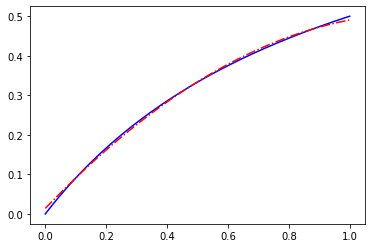

In [8]:
f = lambda x: x/(x+1)
solve(f, 2)

(0.002721517318214 + x*(0.938928960438372 + x*(-0.664598620205411 + x*0.224798782467834)))
MSE is 0.000001


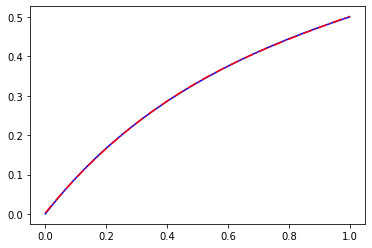

In [9]:
solve(f, 3)

(0.068528197525549 + x*0.476649244454012)
MSE is 0.000614


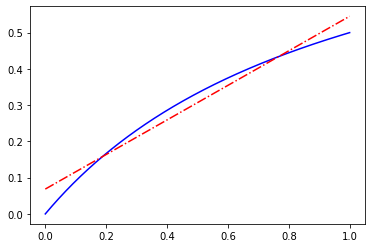

In [10]:
solve(f, 1)

(0.303447666476664 + x*(0.347717512645012 + x*(-3.553070091873221 + x*3.982981984249812)))
MSE is 0.186533


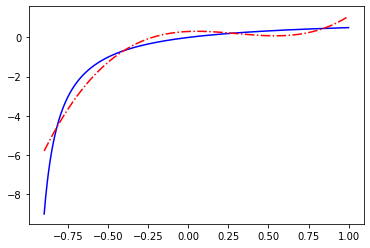

In [11]:
solve(f, 3, bounds=[-0.9,1]) # goes near a singularity

(0.870117144366509 + x*(0.155095193983420 + x*(-0.079101328054017 + x*0.062936403380600)))
MSE is 0.000041


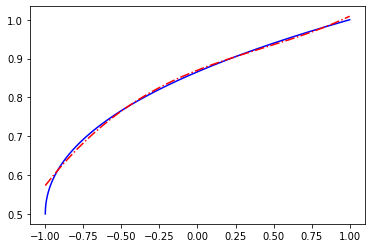

In [12]:
solve(lambda x: np.cos(np.arccos(x)/3), 3, bounds=[-1,1])

(0.864555391677718 + x*(0.155095193983420 + x*(-0.023483801166103 + x*(0.062936403380600 + x*-0.064887114702567))))
MSE is 0.000017


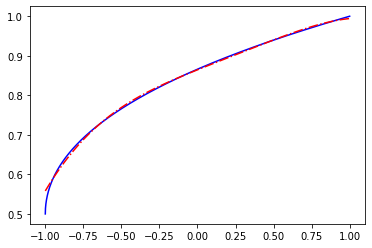

In [13]:
solve(lambda x: np.cos(np.arccos(x)/3), 4, bounds=[-1,1])

(0.085449328808571 + x*(0.000000000000087 + x*(2.307126275098212 + x*(-0.000000000000735 + x*(-2.819815398341568 + x*(0.000000000001554 + x*(1.466301614122375 + x*-0.000000000000936)))))))
MSE is 0.000509


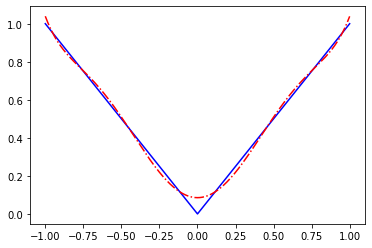

In [14]:
solve(lambda x: abs(x), 7, bounds=[-1,1])

(-0.000000000000000 + x*(3.103460496603129 + x*(0.000000000000001 + x*(-4.814388730974032 + x*(-0.000000000000001 + x*1.726905637894786)))))
MSE is 0.000018


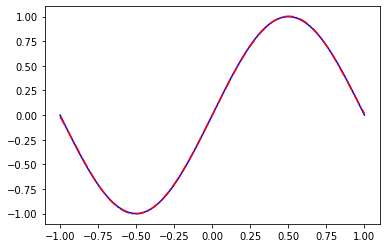

In [15]:
solve(lambda x: np.sin(np.pi * x), 5, bounds=[-1,1])

(0.000000000000001 + x*(2.008197095038624 + x*(-0.000000000000001 + x*(-2.232852181515016 + x*(0.000000000000000 + x*0.453821041078360)))))
MSE is 0.046686


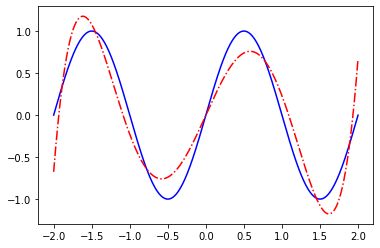

In [16]:
solve(lambda x: np.sin(np.pi * x), 5, bounds=[-2,2])

(0.000000000000002 + x*(2.909032213060851 + x*(-0.000000000000006 + x*(-4.259731197065141 + x*(0.000000000000004 + x*(1.568604499630964 + x*(-0.000000000000001 + x*-0.172526011442668)))))))
MSE is 0.001463


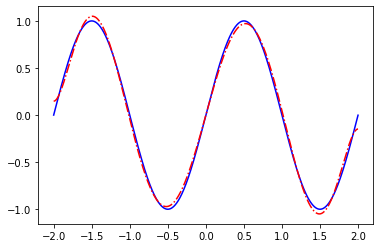

In [17]:
solve(lambda x: np.sin(np.pi * x), 7, bounds=[-2,2])

(0.083918363611151 + x*(2.937021582855697 + x*(-7.831939942650164 + x*(14.097373880972407 + x*(-12.586869947662899 + x*4.307488434884001)))))
MSE is 0.000024


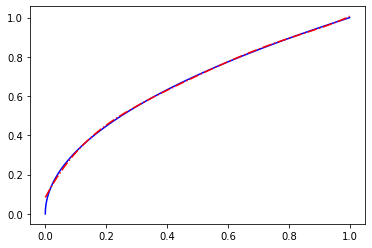

In [18]:
solve(lambda x: np.sqrt(x), 5, bounds=[0,1])

(0.171429108740506 + x*(1.371426454759855 + x*-0.571426826320898))
MSE is 0.000408


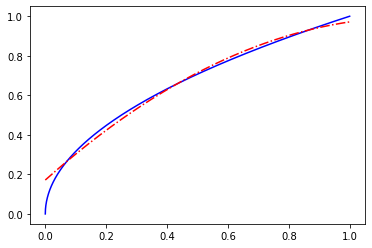

In [19]:
solve(lambda x: np.sqrt(x), 2, bounds=[0,1])

(0.989418064497488 + x*(-0.000000000000001 + x*(-0.322142354505779 + x*(0.000000000000006 + x*(-0.483194363571075 + x*-0.000000000000005)))))
MSE is 0.000269


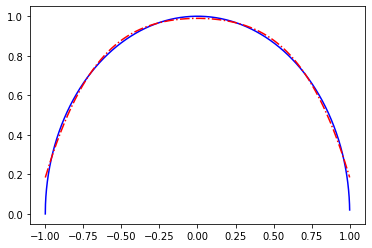

In [20]:
solve(lambda x: np.sqrt(1.0 - x * x), 5, bounds=[-1,1])

(1.010054768091424 + x*(-0.367200305140966 + x*(2.579348497887213 + x*(-9.745455652187395 + x*(12.852818459638542 + x*-6.210233865148290)))))
MSE is 0.000050


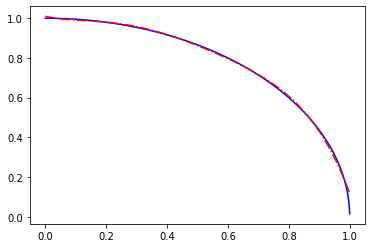

In [21]:
solve(lambda x: np.sqrt(1.0 - x * x), 5, bounds=[0,1])

(0.078125066742717 + x*(-2.281252046007681 + x*(29.531265328168566 + x*(-91.875043587335668 + x*(108.281301890191529 + x*-43.312521805996738)))))
MSE is 0.006104


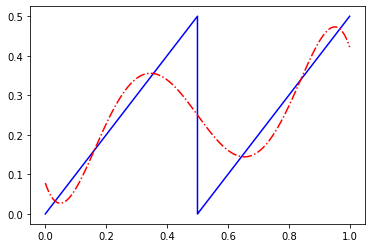

In [22]:
solve(lambda x: np.mod(x, 0.5), 5, bounds=[0,1])

(-0.495321653164403 + x*(78.610358081397393 + x*(-2976.802231943212064 + x*(48747.749434066761751 + x*(-421396.569924201525282 + x*(2118545.954697067849338 + x*(-6378991.709201641380787 + x*(10899719.153942758217454 + x*(-7260372.021865301765501 + x*(-7635417.500231115147471 + x*(16701214.054708126932383 + x*(-1740450.565716905519366 + x*(-22415162.895380906760693 + x*(26979572.793800514191389 + x*(-13507175.761317869648337 + x*2614066.903926628176123)))))))))))))))
MSE is 0.012101


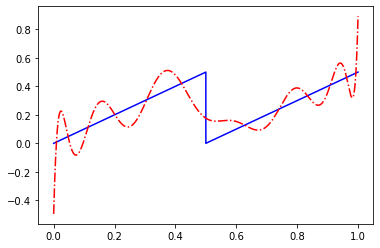

In [23]:
solve(lambda x: np.mod(x, 0.5), 15, bounds=[0,1])

(0.999060083202183 + x*(1.018299553747033 + x*(0.421248129954773 + x*0.278623697396514)))
MSE is 0.000000


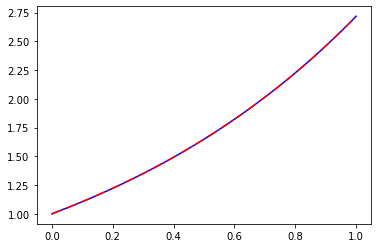

In [24]:
solve(lambda x: np.exp(x), 3, bounds=[0,1])

(-1677.374482619261698 + x*(2804.805927511428308 + x*(-952.207742380350282 + x*86.384597648460101)))
MSE is 868035.295284


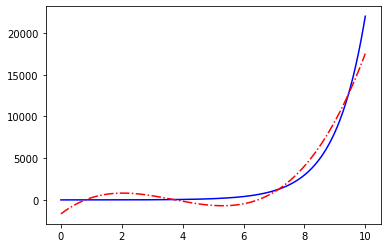

In [25]:
solve(lambda x: np.exp(x), 3, bounds=[0,10])

(1.695722473319867 + x*(-7.904732219177194 + x*(28.405218804938350 + x*(-37.231298713773498 + x*(26.634200896845226 + x*(-11.137906883495814 + x*(2.900185452283417 + x*(-0.474404734767295 + x*(0.047850926027976 + x*(-0.002729149771120 + x*0.000069186117343))))))))))
MSE is 0.033674


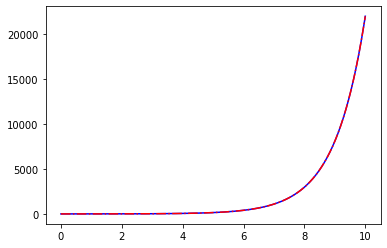

In [26]:
solve(lambda x: np.exp(x), 10, bounds=[0,10])

Bonus round : incorporating constraints
======================

A frequent desire is to come up with a polynomial approximation for a function that
minimizes, e.g., the MSE subject to interpolating the endpoints.

It turns out there's a fairly simple transformation to turn the above solution into such a device.

Let $n$ be 1 more than the degree of your polynomial (i.e. the number of coefficients you have to solve for).

Constraining the endpoints (or, hey, any arbitrary sequence of k points) to hit the approximating curve
can be expressed as an affine transformation (matrix + vector) mapping the last $n-k$ coefficients onto the full $n$ coefficients such that the solution at the constraint points matches the function.

I apologize for not writing this part out in as much detail as the parts above, but it should be possible to work through it on your own.  The code is there.

Then if $\alpha_{full} = M \alpha_{fewer} + v$ the expression $\alpha^T A \alpha - 2B \alpha + C$ can be rewritten
as $\alpha_{fewer}^T M^T A M \alpha_{fewer} - 2 (B - v^T M) \alpha_{fewer} + v^T v + C$.

This can be solved in the same way as the earlier matrix quadratic equation, and then $\alpha_{full}$ can be found
from $\alpha_{fewer}$ via $\alpha_{full} = M \alpha_{fewer} + v$

In [27]:
def make_constraint_rows(f, degree, x_vals, f_vals = None):
    if f_vals is None:
        f_vals = [f(x) for x in x_vals]
    lhs = [[x**n for n in range(len(x_vals))] for x in x_vals] # matrix of polynomial terms
    rhs = [[-x**n for n in range(len(x_vals), degree+1)] for x in x_vals]
    rhs = np.array(rhs)
    lhs = np.array(lhs)
    mat_term = np.linalg.solve(lhs, rhs)
    const_offsets = np.linalg.solve(lhs, np.array(f_vals))
    mat_term = np.vstack([mat_term, np.eye(degree + 1 - len(x_vals))])
    const_offsets = np.hstack([const_offsets, np.zeros(degree + 1 - len(x_vals))])
    return (mat_term, const_offsets)

In [28]:
def solve_with_constraints(f, degree, bounds=[0.0, 1.0], constrain_at=None, n_integration_steps=10000):
    if constrain_at is None:
        constrain_at = [x for x in bounds]
    (lin_mat, offset) = make_constraint_rows(f, degree, constrain_at)
    A = get_a(degree+1, bounds=bounds)
    B = get_b(degree+1, f, bounds=bounds, nsteps=n_integration_steps)
    Aprime = np.dot(lin_mat.T, np.dot(A, lin_mat))
    Bprime = np.dot(B, lin_mat) + 2.0 * np.dot(lin_mat.T, np.dot(A, offset))
    coeffs_prime = solve_coeffs(Aprime, Bprime, None)
    coeffs = np.dot(lin_mat, coeffs_prime) + offset
    f_approx = lambda x: horner(x, coeffs)
    xs = [bounds[0] + (bounds[1] - bounds[0]) * i / n_integration_steps for i in range(n_integration_steps+1)]
    plt.plot(xs, [f(x) for x in xs], 'b-')
    plt.plot(xs, [f_approx(x) for x in xs], 'r-.')
    print(horner_string(coeffs))
    mse = integrate(lambda x: (f_approx(x) - f(x))**2, bounds=bounds, nsteps=n_integration_steps)
    mse = mse/(bounds[1] - bounds[0])
    print("MSE is {:f}".format(mse))
    print(",".join([str(t) + "->" + str(f_approx(t)) for t in constrain_at]))
    print("vs")
    print(",".join([str(t) + "->" + str(f(t)) for t in constrain_at]))
    

(0.000000000000000 + x*(2.761904687299738 + x*(-3.428571179657581 + x*1.666666492357842)))
MSE is 0.001285
0->0.0,1->1.0
vs
0->0.0,1->1.0


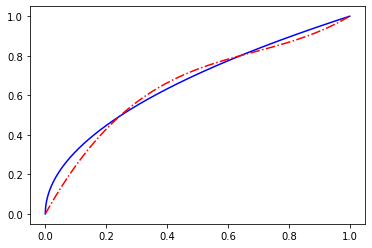

In [29]:
solve_with_constraints(lambda x: np.sqrt(x), 3, bounds=[0,1])

(0.126985126835396 + x*(1.904754237621170 + x*(-1.904746283474184 + x*0.888879638102191)))
MSE is 0.000126


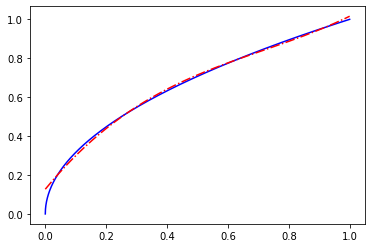

In [30]:
solve(lambda x: np.sqrt(x), 3, bounds=[0,1])

(0.000000000000000 + x*(3.560606324831727 + x*(-7.954547125672469 + x*(9.121215109323837 + x*-3.727274308483095))))
MSE is 0.000497
0->0.0,1->1.0
vs
0->0.0,1->1.0


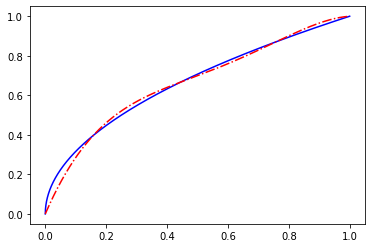

In [31]:
solve_with_constraints(lambda x: np.sqrt(x), 4, bounds=[0,1])

(0.000000000000000 + x*(4.342656648209342 + x*(-14.993000036069951 + x*(29.454523517135417 + x*(-27.188784009800614 + x*9.384603880525805)))))
MSE is 0.000233
0->0.0,1->1.0
vs
0->0.0,1->1.0


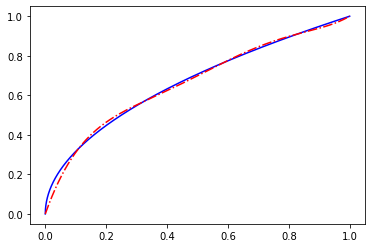

In [32]:
solve_with_constraints(lambda x: np.sqrt(x), 5, bounds=[0,1])

(0.002721517318214 + x*(0.938928960438372 + x*(-0.664598620205411 + x*0.224798782467834)))
MSE is 0.000001


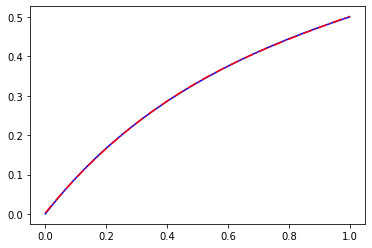

In [33]:
solve(lambda x: x/(x+1), 3)

(0.000000000000000 + x*(0.954278301627844 + x*(-0.685173225190097 + x*0.230894923562253)))
MSE is 0.000001
0.0->0.0,1.0->0.5
vs
0.0->0.0,1.0->0.5


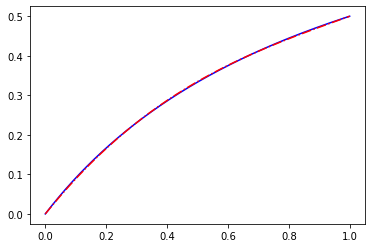

In [34]:
solve_with_constraints(lambda x: x/(x+1), 3)

(0.013961456441606 + x*(0.804049690957671 + x*-0.327400446503659))
MSE is 0.000019


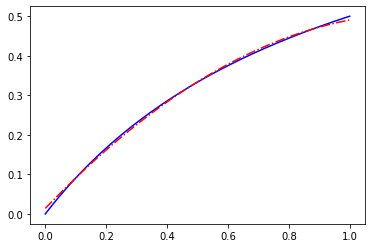

In [35]:
solve(lambda x: x/(x+1), 2)

(0.000000000000000 + x*(0.838830839846718 + x*-0.338830839846718))
MSE is 0.000065
0.0->0.0,1.0->0.49999999999999994
vs
0.0->0.0,1.0->0.5


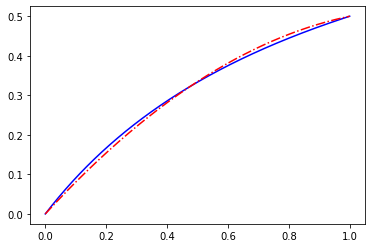

In [36]:
solve_with_constraints(lambda x: x/(x+1), 2)

(0.052426898789506 + x*(-5.004849483378008 + x*(163.550121006373814 + x*(-1846.112515108447042 + x*(10718.793435251431220 + x*(-35727.864954095639405 + x*(72721.112345278481371 + x*(-93321.007200281324913 + x*(75791.723229374038056 + x*(-37775.486890568739909 + x*(10541.113533141840890 + x*-1260.628760853132007)))))))))))
MSE is 0.005668


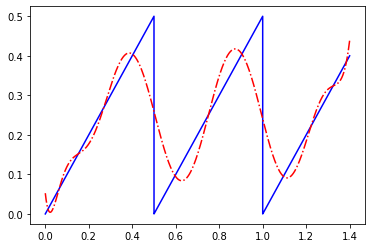

In [37]:
solve(lambda x: np.mod(x, 0.5), 11, bounds=[0,1.4])

(0.000000000000000 + x*(-1.841788455199484 + x*(104.805337328091781 + x*(-1338.391506623980831 + x*(8280.509218541719747 + x*(-28590.521135327904631 + x*(59345.064929686792311 + x*(-76942.489952294403338 + x*(62758.393756453006063 + x*(-31283.778671803240286 + x*(8703.681397280750389 + x*-1035.187614584092444)))))))))))
MSE is 0.005709
0->0.0,1.4->0.40000000000873115
vs
0->0.0,1.4->0.3999999999999999


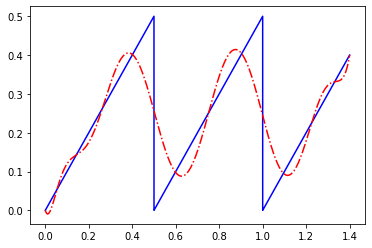

In [38]:
solve_with_constraints(lambda x: np.mod(x, 0.5), 11, bounds=[0,1.4])

Comparison to experiments by Inigo Quilez
------------------------------------------------------

Here we try to use this approach to work with the problems studied in

https://www.iquilezles.org/www/articles/trisect/trisect.htm

First we try to find polynomial fits directly

(0.861282332201587 + x*(0.131118892006436 + x*(0.022339031499730 + x*(0.118881107993564 + x*-0.133621363701317))))
MSE is 0.000165
-1->0.49999999999999994,1->1.0
vs
-1->0.5000000000000001,1->1.0


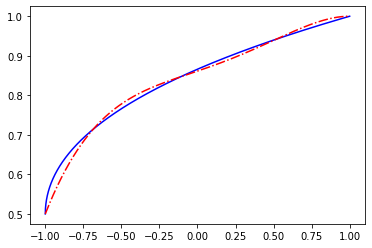

In [39]:
solve_with_constraints(lambda x: np.cos(np.arccos(x)/3), 4, bounds=[-1,1])

(0.864555391677718 + x*(0.155095193983420 + x*(-0.023483801166103 + x*(0.062936403380600 + x*-0.064887114702567))))
MSE is 0.000017


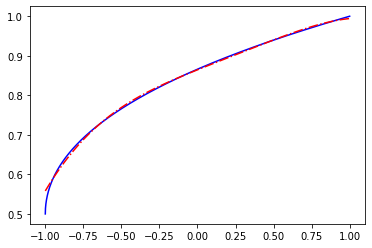

In [40]:
solve(lambda x: np.cos(np.arccos(x)/3), 4, bounds=[-1,1])

Well, that didn't work too well.  But IQ's original approach first transformed to $x \leftarrow \sqrt{{x+1}\over{2}}$.

Let's try fitting polynomials to $f(x) = \cos(\arccos(2x^2-1)/3)$

(0.500000000000000 + x*(0.576921123432283 + x*(-0.106840851033954 + x*(0.038769550530970 + x*-0.008849822929299))))
MSE is 0.000000
0.0->0.5000000000000001,1.0->0.9999999999999998
vs
0.0->0.5000000000000001,1.0->1.0


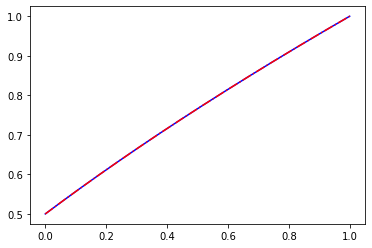

In [41]:
solve_with_constraints(lambda x: np.cos(np.arccos(2*x*x-1)/3), 4)

In [42]:
def quilez_approx_4(t):
    x = np.sqrt(0.5 + 0.5 * t)
    return (0.500000000000000 + x*(0.576921123432283 +
                                   x*(-0.106840851033954 + x*(0.038769550530970 + x*-0.008849822929299))))

In [43]:
integrate(lambda x: (quilez_approx_4(x) - np.cos(np.arccos(x)/3))**2, bounds=[-1,1])/2

4.7747953643430224e-11

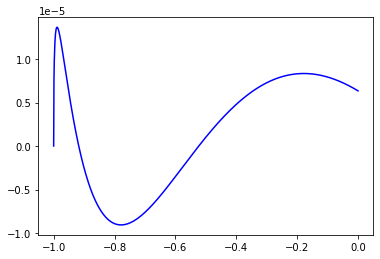

In [44]:
xs = [-1.0 + 0.001 * x for x in range(1001)]
plt.plot(xs, [np.cos(np.arccos(x)/3) - quilez_approx_4(x) for x in xs], 'b-')

(0.500000000000000 + x*(0.575024732804577 + x*(-0.096094637476950 + x*0.021069904672373)))
MSE is 0.000000
0.0->0.5000000000000001,1.0->0.9999999999999999
vs
0.0->0.5000000000000001,1.0->1.0


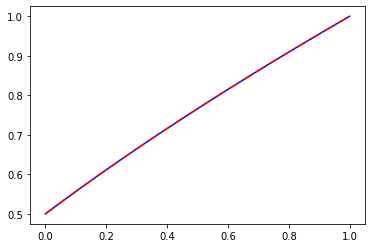

In [45]:
solve_with_constraints(lambda x: np.cos(np.arccos(2*x*x-1)/3), 3)

In [46]:
def quilez_approx_3(t):
    x = np.sqrt(0.5 + 0.5 * t)
    return (0.500000000000000 + x*(0.575024732804577 + x*(-0.096094637476950 + x*0.021069904672373)))

In [47]:
integrate(lambda x: (quilez_approx_3(x) - np.cos(np.arccos(x)/3))**2, bounds=[-1,1])/2

4.038268450590175e-09

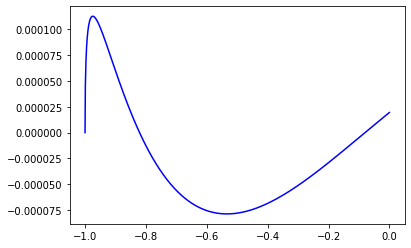

In [48]:
xs = [-1.0 + 0.001 * x for x in range(1001)]
plt.plot(xs, [np.cos(np.arccos(x)/3) - quilez_approx_3(x) for x in xs], 'b-')

(0.500000000000000 + x*(0.564489780468390 + x*-0.064489780468390))
MSE is 0.000001
0.0->0.5000000000000001,1.0->1.0
vs
0.0->0.5000000000000001,1.0->1.0


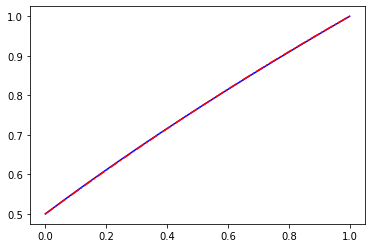

In [49]:
solve_with_constraints(lambda x: np.cos(np.arccos(2*x*x-1)/3), 2)

In [50]:
def quilez_approx_2(t):
    x = np.sqrt(0.5 + 0.5 * t)
    return (0.500000000000000 + x*(0.564489780468390 + x*-0.064489780468390))

In [51]:
integrate(lambda x: (quilez_approx_2(x) - np.cos(np.arccos(x)/3))**2, bounds=[-1,1])/2

4.902746465127598e-07

Huh, that's worse than IQ's claim of `4.15e-07`  Let's integrate for a million steps, like he does

Because this takes a long time, I converted this cell to a markdown cell, and just copy-pasted the results

`integrate(lambda x: (quilez_approx_2(x) - np.cos(np.arccos(x)/3))**2, bounds=[-1,1], nsteps=1000000)/2`

gives

`4.90274579581385e-07`

Nope, still worse.  Maybe it's a roundoff or cut-and-paste error.

Anyway, I guess the fact that this technique doesn't handle roundoff error is a potential flaw

(0.500000000000000 + x*(0.564489761720064 + x*-0.064489761720064))
MSE is 0.000001
0.0->0.5000000000000001,1.0->0.9999999999999999
vs
0.0->0.5000000000000001,1.0->1.0


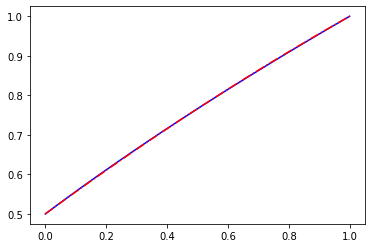

In [52]:
solve_with_constraints(lambda x: np.cos(np.arccos(2*x*x-1)/3), 2, n_integration_steps=1000000)

In [53]:
# I guess we could try solving it with finer integration
def quilez_approx_2b(t):
    x = np.sqrt(0.5 + 0.5 * t)
    return (0.500000000000000 + x*(0.564489761720064 + x*-0.064489761720064))

In [54]:
integrate(lambda x: (quilez_approx_2b(x) - np.cos(np.arccos(x)/3))**2, bounds=[-1,1], nsteps=1000000)/2

4.902726984883477e-07

That doesn't work either, theories?
------------------------------

Our technique, as used here, minimizes the MSE against $f(x) = \cos(\arccos(2x^2-1)/3)$,
which is _not_ the same as finding the polynomial of $\sqrt{{x+1}\over{2}}$ that minimizes the MSE with
$f(x) = \cos(\arccos(x)/3)$.

We just got lucky for our higher-degree polynomials, and the difference started to show with the quadratic

Using this technique to approximate inverse functions
===============================

A common problem in many fields is to cook up a fast approximation to the inverse of a known function.

Obviously a straightforward approach would be to plug in a numerical approximator to the inverse into our
current methods, use integrals of powers of x times that to approximate b, and cook up our fast polynomial
approximate inverse.

But other tricks are available.

In particular, in 1 dimension, it is possible to find the integral of the inverse of $f(x)$ without ever inverting $f$ directly

Without getting into too many details, the formula we use is a generalization of the well-known

$$ \int_{f(a)}^{f(b)} f^{-1}(y) dy = a (f(b) - f(a)) + f(b) (b - a) - \int_a^b f(x) dx $$

for monotonically non-decreasing $f$

In particular, define $k$ such that we are trying to find $ \int_{f(a)}^{f(b)} y^k f^{-1}(y) dy$

if we define $g(x) = \frac{f(x)^{k+1}}{k+1}$ it can be shown that

$$ \int_{f(a)}^{f(b)} y^k f^{-1}(y) dy = a (g(b) - g(a)) + g(b) (b - a) - \int_a^b g(x) dx $$

From there, we can use that integral to compute the terms in the matrix $B$ in our original calculation, but for
$f^{-1}(y)$ without evaluating $f^{-1}(y)$ directly.

As a note : the actual code has conditionals to handle the variant for monotonically non-increasing $f$ as well as monotonically non-decreasing $f$


In [55]:
def integrate_inv_pow(f, pow_of_x, f_bounds, nsteps=10000):
    """Here we express the "integral of the inverse times a power of y"
    trick outlined above in python code, relying on our earlier numerical integration routine"""
    mod_f = lambda x: f(x) ** (pow_of_x + 1) / (pow_of_x + 1)
    rect0_area = (f_bounds[1] - f_bounds[0]) * max(mod_f(f_bounds[0]), mod_f(f_bounds[1]))
    rect1_area = f_bounds[0] * abs(mod_f(f_bounds[1]) - mod_f(f_bounds[0]))
    int_x_df = integrate(mod_f, bounds=f_bounds, nsteps = nsteps)
    return rect0_area - int_x_df + rect1_area

Let's test to see if this integration trick works!

In [56]:
integrate_inv_pow(lambda x: x * x, 0, [2, 3]) # inverse of x*x is np.sqrt(x)

12.666666667500023

In [57]:
integrate(lambda x: np.sqrt(x), bounds=[4,9]) # applying f(x)=x*x to the bounds above gives [4,9]

12.66666666753467

Hey, same answer!  We can use this now!

First a few more tests for the heck of it.

In [58]:
integrate_inv_pow(lambda x: x * x, 1, [2, 3])

84.40000001583337

In [59]:
integrate(lambda x: x * np.sqrt(x), bounds=[4,9])

84.39999998437479

Re-formulation of MSE-minimizing matrices
------------------------------

Here we'll use the above inverse integration formula to get $A$ and $B$ matrices for the
"fit a polynomial to the inverse of a given function" problem.

Note that we don't explicitly compute $C$ here.  The original formulas didn't need it either.

In [60]:
def inv_get_a(n, f, bounds=[0.0, 1.0]):
    x0 = f(bounds[0])
    x1 = f(bounds[1])
    x0, x1 = min(x0, x1), max(x0, x1)
    els = [[(x1 **  (i + j + 1) - x0 ** (i + j + 1))/(i+j+1) for j in range(n)] for i in range(n)]
    return np.array(els)

def inv_get_b(n, f, bounds=[0.0, 1.0], nsteps=10000):
    els = [-2.0 * integrate_inv_pow(f, i, f_bounds=bounds, nsteps=nsteps) for i in range(n)]
    return np.array(els)


In [61]:
def inv_solve(f, degree, bounds=[0.0, 1.0], n_integration_steps=10000):
    """Find the best MSE polynomial of degree "degree"
    for the inverse of a monotonic function f
    between f(bounds[0]) and f(bounds[1])"""
    A = inv_get_a(degree+1, f, bounds=bounds)
    B = inv_get_b(degree+1, f, bounds=bounds, nsteps=n_integration_steps)
    coeffs = solve_coeffs(A, B, None)
    f_approx = lambda x: horner(x, coeffs)
    xs = [bounds[0] + (bounds[1] - bounds[0]) * i / n_integration_steps for i in range(n_integration_steps)]
    plt.plot([f(x) for x in xs], xs, 'b-')
    y_bounds = [f(b) for b in bounds]
    ys = [y_bounds[0] + (y_bounds[1] - y_bounds[0]) * i / n_integration_steps for i in range(n_integration_steps)]
    plt.plot(ys, [f_approx(y) for y in ys], 'r-.')
    plt.title("Approximation vs $f^{-1}$")
    print(horner_string(coeffs))
    round_trip = lambda x: f_approx(f(x))
    inv_round_trip = lambda y: f(f_approx(y))
    def round_trip_sqrd_err(x):
        delta = round_trip(x) - x
        return delta * delta
    def inv_round_trip_sqrd_err(x):
        delta = inv_round_trip(x) - x
        return delta * delta
    plt.figure()
    plt.plot(xs, [ round_trip(x) - x for x in xs], 'b-')
    plt.title("$f^{-1}_{approx}(f(x)) - x$")
    plt.figure()
    plt.plot(ys, [ inv_round_trip(y) - y for y in ys], 'b-')
    plt.title("$f(f^{-1}_{approx}(y)) - y$")
    round_trip_mse = integrate(round_trip_sqrd_err, bounds=bounds, nsteps = n_integration_steps)/(bounds[1] - bounds[0])
    print("Round trip mse is " + str(round_trip_mse))
    inv_round_trip_mse = integrate(inv_round_trip_sqrd_err, bounds=y_bounds, nsteps = n_integration_steps)/(y_bounds[1] - y_bounds[0])
    print("f(f_inv(y)) round trip mse is " + str(inv_round_trip_mse))

As a note, instead of directly computing the MSE of the function, this computes the MSE of the round-trip
functions $f(f^{-1}(y))$ and $f^{-1}(f(x))$

It then plots, not only the approximation super-imposed on the inverse (plotted by flipping the x and y axes
and plotting $f(x)$), but also the error $f(f{-1}(y)) - y$ and $f^{-1}(f(x)) - x$ between the appropriate bounds

We first test by finding polynomial approximations for the function $f(y) = \sqrt{y}$ by approximating the inverse of $f(x) = x^2$

(0.605876409964329 + x*(0.497899753994002 + x*(-0.053740567597264 + x*(0.005143945790541 + x*(-0.000288903996998 + x*0.000006970253968)))))
Round trip mse is 1.640252982242332e-11
f(f_inv(y)) round trip mse is 3.8410547291097856e-10


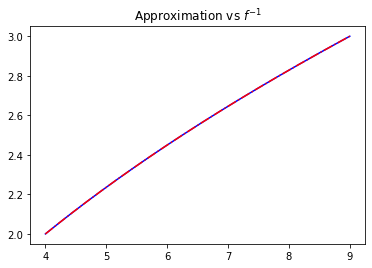

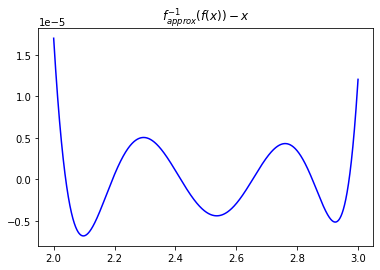

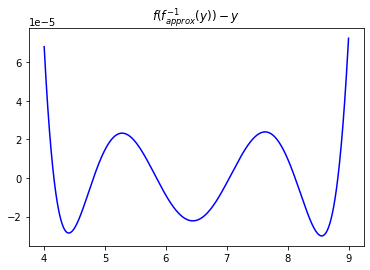

In [62]:
inv_solve(lambda x : x*x, 5, bounds=[2,3])

(0.606730891058431 + x*(0.466299878991774 + x*(-0.037838209882226 + x*(0.002331284260265 + x*(-0.000075323925901 + x*0.000000961759453)))))
Round trip mse is 4.87686218544187e-05
f(f_inv(y)) round trip mse is 0.0007416306932290037


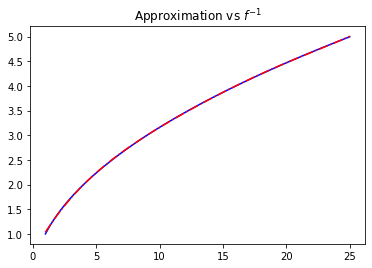

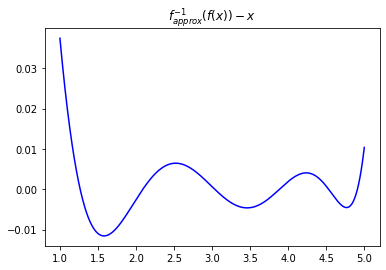

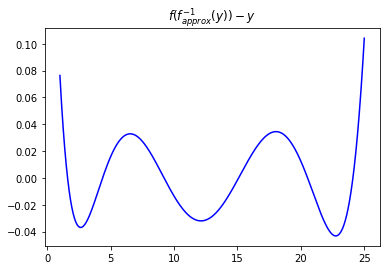

In [63]:
inv_solve(lambda x : x*x, 5, bounds=[1,5])

(0.083916078912897 + x*(2.937063112155099 + x*(-7.832169232794238 + x*(14.097906299533966 + x*(-12.587417839214343 + x*4.307694618402058)))))
Round trip mse is 0.0002514352499115071
f(f_inv(y)) round trip mse is 1.3127933942707755e-05


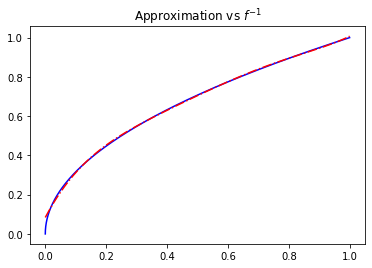

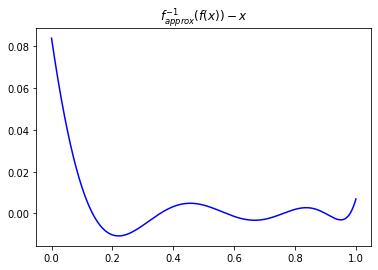

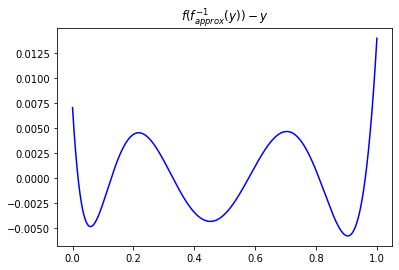

In [64]:
inv_solve(lambda x : x*x, 5, bounds=[0,1])

Having tried that, we turn our attention to polynomial approximations of the inverse of the "smoothstep" cubic
function common in computer graphics.

$f_{smoothstep}(x) = 3x^2 - 2 x ^3$ for $x \in [0,1]$, $0$ for $x < 0$ and $1$ for $x > 1$.

We only really care about the inverse in the interval $[0,1]$

(0.044339561364995 + x*(1.963519452752245 + x*(-5.625755050365454 + x*(11.981034446625994 + x*(-12.345796619556637 + x*4.938318647813174)))))
Round trip mse is 7.575044874008052e-05
f(f_inv(y)) round trip mse is 5.491443812365619e-06


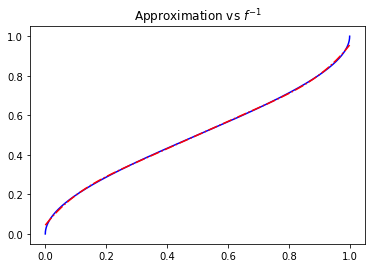

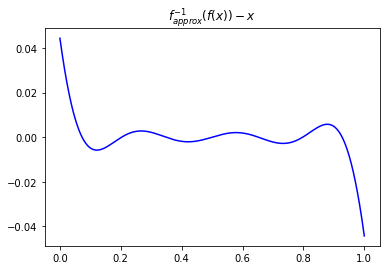

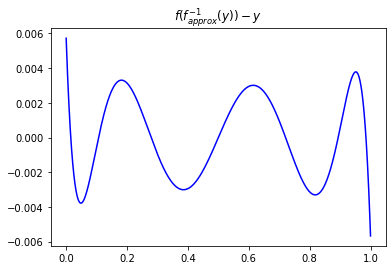

In [65]:
inv_solve(lambda x : x*x*(3 - 2*x), 5, bounds=[0.0,1.0])

(0.033929402787270 + x*(2.546488329037126 + x*(-13.495834842326980 + x*(55.703699803555708 + x*(-132.583126027829820 + x*(178.080072628572054 + x*(-125.046822104920466 + x*35.727663407940362)))))))
Round trip mse is 3.376763500305388e-05
f(f_inv(y)) round trip mse is 1.6007179447321844e-06


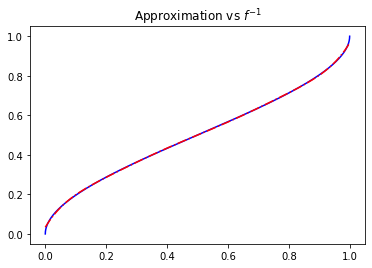

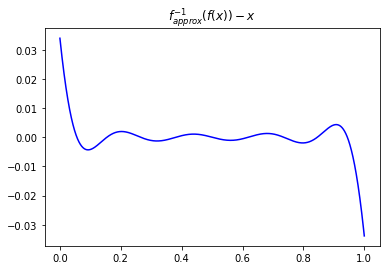

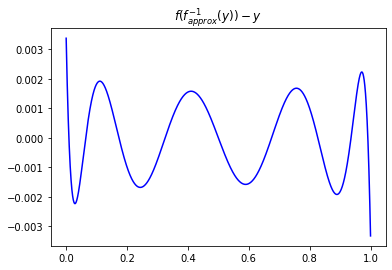

In [66]:
inv_solve(lambda x : x*x*(3 - 2*x), 7, bounds=[0.0,1.0])

(0.063936063935996 + x*(1.375624375625042 + x*(-1.510489510490987 + x*1.006993006993915)))
Round trip mse is 0.000228786860911264
f(f_inv(y)) round trip mse is 2.8306237933401073e-05


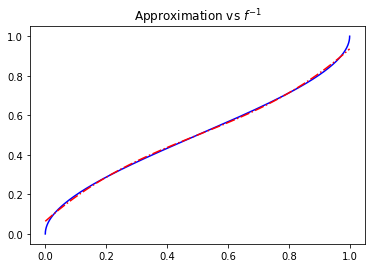

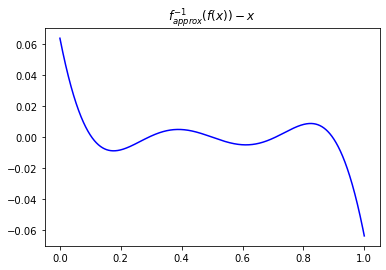

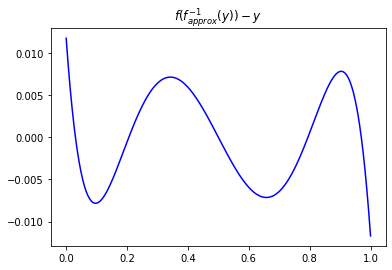

In [67]:
inv_solve(lambda x : x*x*(3 - 2*x), 3, bounds=[0.0,1.0])

Huh, all of these fits look close enough to linear that I'm curious what the linear fit looks like

(0.114285714285711 + x*0.771428571428578)
Round trip mse is 0.001310009527696733
f(f_inv(y)) round trip mse is 0.00033250164584870304


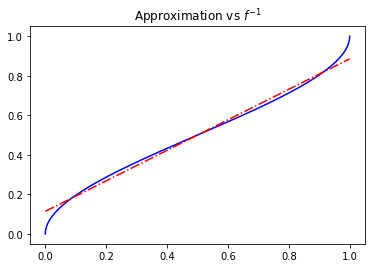

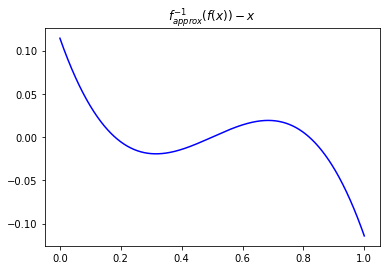

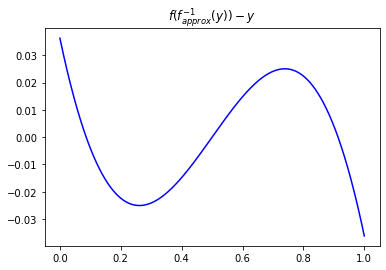

In [68]:
inv_solve(lambda x : x*x*(3 - 2*x), 1, bounds=[0.0,1.0])

And I'm curious as to what the fit looks like if restricted to a sub-interval of $[0.0, 1.0]$

(0.079428464441295 + x*(1.239733667254823 + x*(-1.195771788412236 + x*0.797181192274826)))
Round trip mse is 1.0456793528993531e-05
f(f_inv(y)) round trip mse is 7.415208320890868e-06


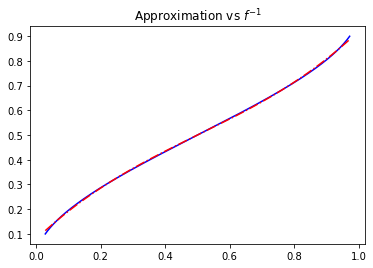

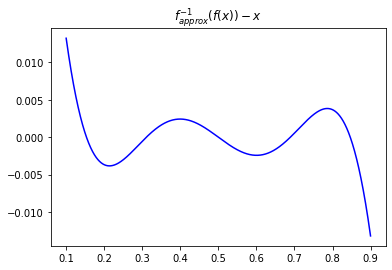

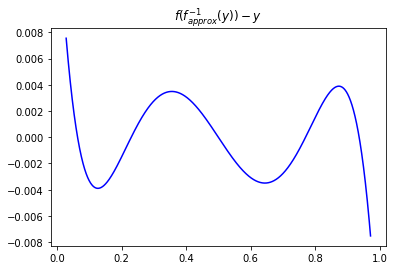

In [69]:
inv_solve(lambda x : x*x*(3 - 2*x), 3, bounds=[0.1,0.9])

Now we turn our attention to the logistic function, once popular as a non-linearity in artificial neural networks.

Recall that the logistic function is $f(x) = \frac{1}{1+e^{-x}}$

This isn't a particularly useful approximation, as the logistic function has a well-known inverse,

but it is interesting to note how the two different round-trip MSE errors (and the two different round-trip 
error plots) differ.

In particular $f^{-1}(f(x)) - x$ has larger errors for $x$ where the function is relatively flat than $f(f^{-1}(y)) - y$

(-4.167597012232570 + x*(27.844337437560558 + x*(-105.283537431689098 + x*(226.042715595601464 + x*(-233.780535961454092 + x*93.512214384433435)))))
Round trip mse is 0.00580185718943398
f(f_inv(y)) round trip mse is 2.15311135223221e-05


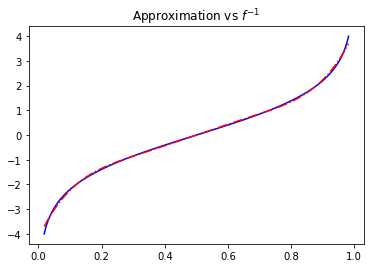

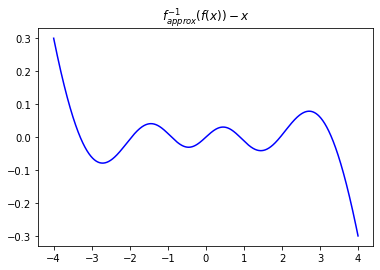

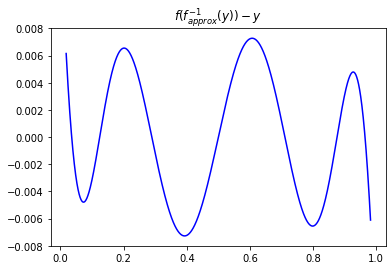

In [70]:
inv_solve(lambda x: 1.0 / (1.0 + np.exp(-x)), 5, bounds=[-4,4])

Below we do another comparison between approximating a function via its inverse vs approximating it directly.

In this case we approximate $f(x) = \ln(x)$ both via its inverse $g(y) = e^y$ and directly.

Note that the terms in the resulting polynomial are quite close.  As they should be.

(-1.772609962863124 + x*(2.965644429605793 + x*(-1.719127093084990 + x*(0.649753619817901 + x*(-0.135228024924742 + x*0.011768200399896)))))
Round trip mse is 2.254231070084347e-09
f(f_inv(y)) round trip mse is 6.1779194676917695e-09


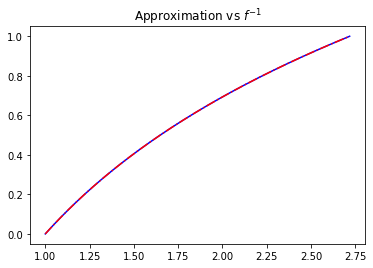

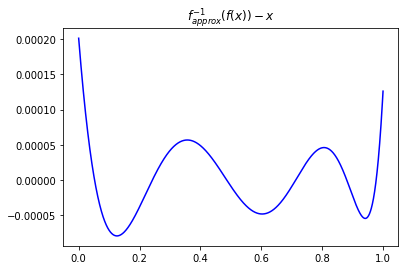

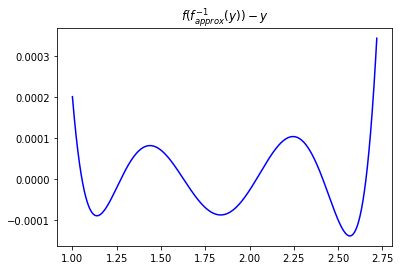

In [71]:
inv_solve(lambda x: np.exp(x), 5, bounds=[0,1])

(-1.772569115937098 + x*(2.965519946569914 + x*(-1.718979273000586 + x*(0.649668085399373 + x*(-0.135203885610543 + x*0.011765539069315)))))
MSE is 0.000000


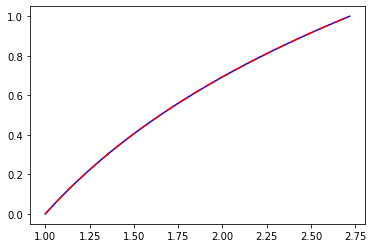

In [72]:
solve(lambda x: np.log(x), 5, bounds=[1.0, np.exp(1)])

Approximation of function inverses with constraints
==========================

Having found how to approximate functions given constraints on where the approximation should match the original
function, and having figured out how to approximate the inverse of a function without calculating the inverse
directly, a natural next step is to combine the two.

The techniques to do so are a straightforward combination of the techniques to do each separately

In [73]:
def make_inv_constraint_rows(f, degree, x_vals):
    f_vals = [f(x) for x in x_vals]
    lhs = [[x**n for n in range(len(x_vals))] for x in f_vals] # matrix of polynomial terms
    rhs = [[-x**n for n in range(len(x_vals), degree+1)] for x in f_vals]
    rhs = np.array(rhs)
    lhs = np.array(lhs)
    mat_term = np.linalg.solve(lhs, rhs)
    const_offsets = np.linalg.solve(lhs, np.array(x_vals))
    mat_term = np.vstack([mat_term, np.eye(degree + 1 - len(x_vals))])
    const_offsets = np.hstack([const_offsets, np.zeros(degree + 1 - len(x_vals))])
    return (mat_term, const_offsets)

In [74]:
def inv_solve_with_constraints(f, degree, bounds=[0.0, 1.0], constrain_at=None, n_integration_steps=10000):
    if constrain_at is None:
        constrain_at = [x for x in bounds]
    (lin_mat, offset) = make_inv_constraint_rows(f, degree, constrain_at)
    A = inv_get_a(degree+1, f, bounds=bounds)
    B = inv_get_b(degree+1, f, bounds=bounds, nsteps=n_integration_steps)
    Aprime = np.dot(lin_mat.T, np.dot(A, lin_mat))
    Bprime = np.dot(B, lin_mat) + 2.0 * np.dot(lin_mat.T, np.dot(A, offset))
    coeffs_prime = solve_coeffs(Aprime, Bprime, None)
    coeffs = np.dot(lin_mat, coeffs_prime) + offset
    f_approx = lambda x: horner(x, coeffs)
    xs = [bounds[0] + (bounds[1] - bounds[0]) * i / n_integration_steps for i in range(n_integration_steps+1)]
    plt.plot([f(x) for x in xs], xs, 'b-')
    y_bounds = [f(b) for b in bounds]
    ys = [y_bounds[0] + (y_bounds[1] - y_bounds[0]) * i / n_integration_steps for i in range(n_integration_steps)]
    plt.plot(ys, [f_approx(y) for y in ys], 'r-.')
    plt.title("Approximation vs $f^{-1}$")
    print(horner_string(coeffs))
    round_trip = lambda x: f_approx(f(x))
    inv_round_trip = lambda y: f(f_approx(y))
    def round_trip_sqrd_err(x):
        delta = round_trip(x) - x
        return delta * delta
    def inv_round_trip_sqrd_err(x):
        delta = inv_round_trip(x) - x
        return delta * delta
    plt.figure()
    plt.plot(xs, [ round_trip(x) - x for x in xs], 'b-')
    plt.title("$f^{-1}_{approx}(f(x)) - x$")
    plt.figure()
    plt.plot(ys, [ inv_round_trip(y) - y for y in ys], 'b-')
    plt.title("$f(f^{-1}_{approx}(y)) - y$")
    round_trip_mse = integrate(round_trip_sqrd_err, bounds=bounds, nsteps = n_integration_steps)/(bounds[1] - bounds[0])
    print("Round trip mse is " + str(round_trip_mse))
    inv_round_trip_mse = integrate(inv_round_trip_sqrd_err, bounds=y_bounds, nsteps = n_integration_steps)/(y_bounds[1] - y_bounds[0])
    print("f(f_inv(y)) round trip mse is " + str(inv_round_trip_mse))

So, let's make an MSE-minimizing approximation of $f(x) = 3x^2 - 2x^3$ subject to the approximation matching
the function at the endpoints $0$ and $1$.

(0.000000000000000 + x*(1.951048951049035 + x*(-2.853146853147071 + x*1.902097902098035)))
Round trip mse is 0.0006689964013832456
f(f_inv(y)) round trip mse is 0.0003323893975048503


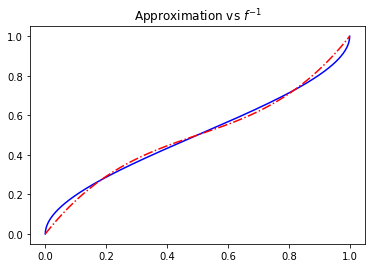

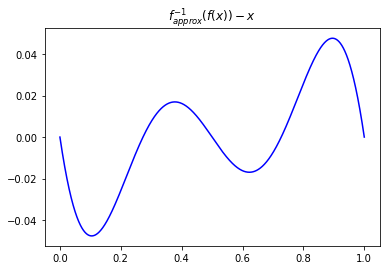

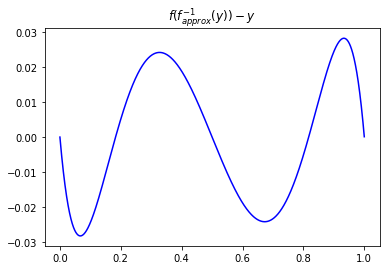

In [75]:
inv_solve_with_constraints(lambda x : x*x*(3 - 2*x), 3, bounds=[0.0,1.0])

That's awfully rough.  Let's try the thing with some higher degree polynomials

(0.000000000000000 + x*(3.734017342331811 + x*(-26.558653451928912 + x*(121.017791326092748 + x*(-302.399761864361267 + x*(415.823361449307640 + x*(-294.863456750741307 + x*84.246701949299336)))))))
Round trip mse is 8.862689076592309e-05
f(f_inv(y)) round trip mse is 1.6506542639874848e-05


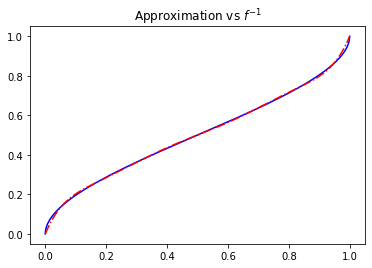

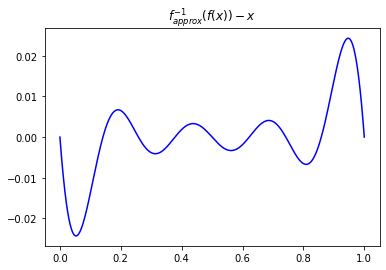

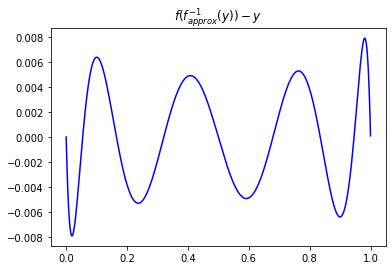

In [76]:
inv_solve_with_constraints(lambda x : x*x*(3 - 2*x), 7, bounds=[0.0,1.0])

(0.000000000000000 + x*(4.610976284489880 + x*(-51.990559512089490 + x*(384.984205188416581 + x*(-1659.067467618041974 + x*(4326.225761924431936 + x*(-6918.616409103511614 + x*(6628.203759484744296 + x*(-3488.594125535026251 + x*775.243858886585599)))))))))
Round trip mse is 4.5984724701287355e-05
f(f_inv(y)) round trip mse is 5.980200923776714e-06


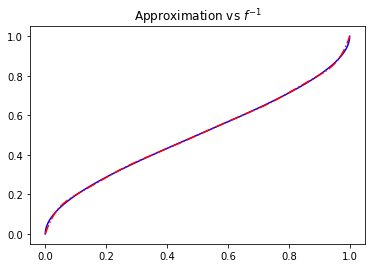

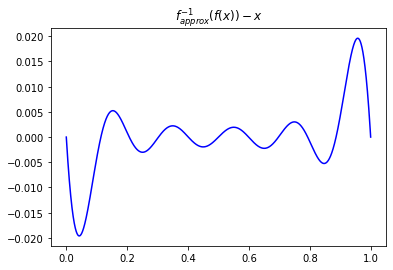

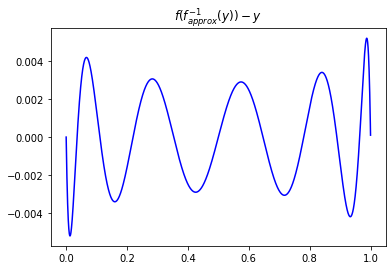

In [77]:
inv_solve_with_constraints(lambda x : x*x*(3 - 2*x), 9, bounds=[0.0,1.0])

(0.000000000000000 + x*(5.459394410354435 + x*(-88.501123140617196 + x*(955.923401909513245 + x*(-6193.200697106994085 + x*(25327.786536022653308 + x*(-67659.145894583591144 + x*(119640.258885765084415 + x*(-138757.132008908753050 + x*(101425.282576240992057 + x*(-42358.725720065041969 + x*7702.994649456396473)))))))))))
Round trip mse is 2.711297143116967e-05
f(f_inv(y)) round trip mse is 2.43462417649429e-06


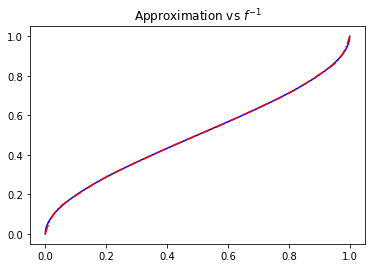

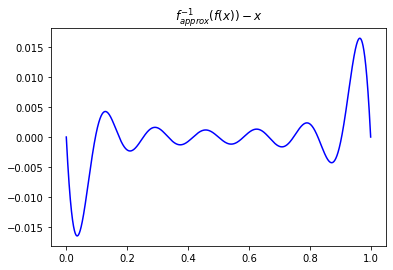

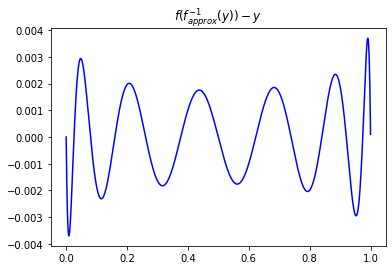

In [78]:
inv_solve_with_constraints(lambda x : x*x*(3 - 2*x), 11, bounds=[0.0,1.0])

Let's try some trig functions!

(0.000000000000000 + x*(0.937040264638351 + x*(-0.000000000000000 + x*(0.892403353107810 + x*(0.000000000000001 + x*(-1.929199151899804 + x*(-0.000000000000001 + x*1.612819189945558)))))))
Round trip mse is 0.000313291869508684
f(f_inv(y)) round trip mse is 3.428643584015656e-05


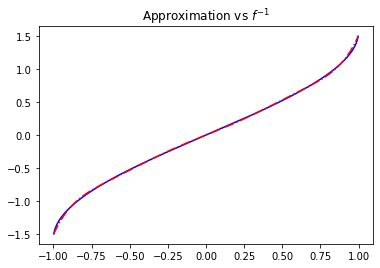

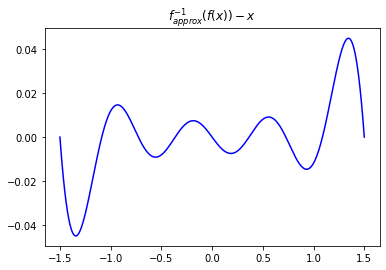

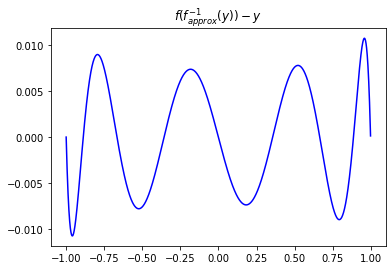

In [79]:
inv_solve_with_constraints(lambda x : np.sin(x), 7, bounds=[-1.5,1.5])

(0.000000000000001 + x*(0.930385203318317 + x*(-0.000000000000000 + x*(-0.157097020238343 + x*(0.000000000000000 + x*(0.018896970964777 + x*(-0.000000000000000 + x*-0.000864547551310)))))))
Round trip mse is 0.00013619514379607371
f(f_inv(y)) round trip mse is 0.002330772181998552


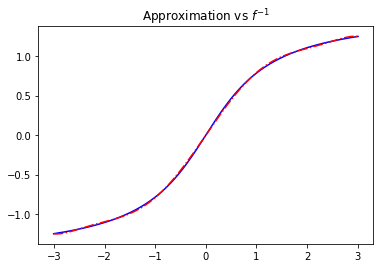

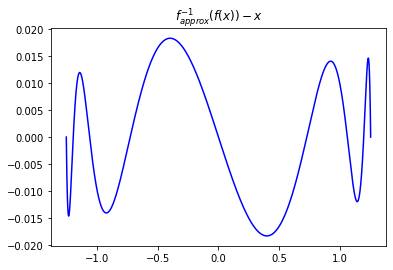

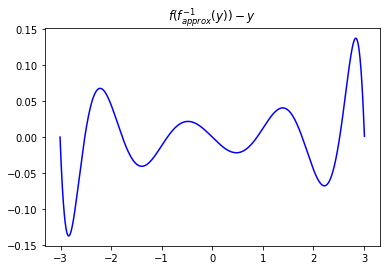

In [80]:
inv_solve_with_constraints(lambda x : np.tan(x), 7, bounds=[-1.25,1.25])

(0.000000000000001 + x*(0.581514970735267 + x*(-0.000000000000000 + x*(-0.018755545020217 + x*(0.000000000000000 + x*(0.000345823422249 + x*(-0.000000000000000 + x*(-0.000003152961847 + x*(0.000000000000000 + x*(0.000000013662298 + x*(-0.000000000000000 + x*-0.000000000022483)))))))))))
Round trip mse is 0.02082585314722857
f(f_inv(y)) round trip mse is 279470.68389871035


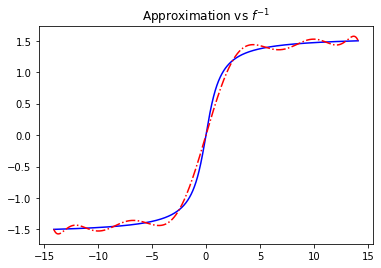

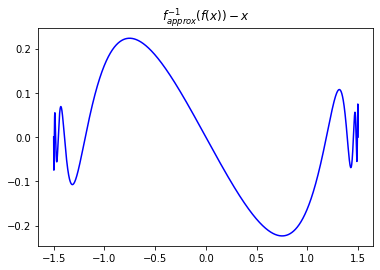

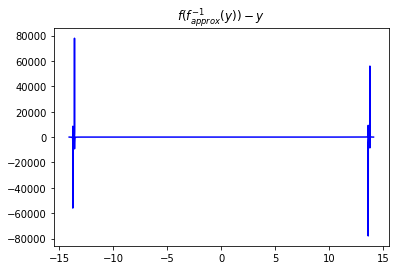

In [81]:
inv_solve_with_constraints(lambda x : np.tan(x), 11, bounds=[-1.5,1.5])

Digression : representing a parametric surface with polynomials
==================

Here we try to use these techniques to represent a patch on a sphere using 4th-order polynomials mapping $u,v \in [0,1] \times [0,1]$ onto $ (x,y,z) \in \mathcal{R}^3$

We do this by first coming up with second-order polynomial approximations to $cos(\pi x / 2)$ and $sin(\pi x / 2)$ constrained at $0$ and $1$, then plugging these into the trig-based parametric equation for a sphere

(0.000000000000000 + x*(1.822194503355188 + x*-0.822194503355188))
MSE is 0.000230
0.0->0.0,1.0->1.0
vs
0.0->0.0,1.0->1.0


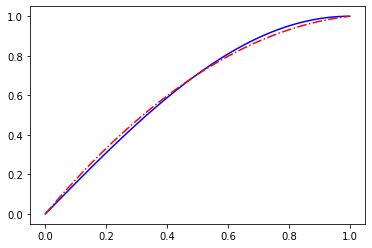

In [88]:
solve_with_constraints(lambda x: np.sin(x*np.pi*0.5), 2)

(1.000000000000000 + x*(-0.177805496644792 + x*-0.822194503355208))
MSE is 0.000230
0.0->1.0,1.0->1.1102230246251565e-16
vs
0.0->1.0,1.0->6.123233995736766e-17


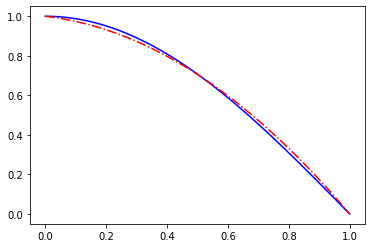

In [89]:
solve_with_constraints(lambda x: np.cos(x*np.pi*0.5), 2)

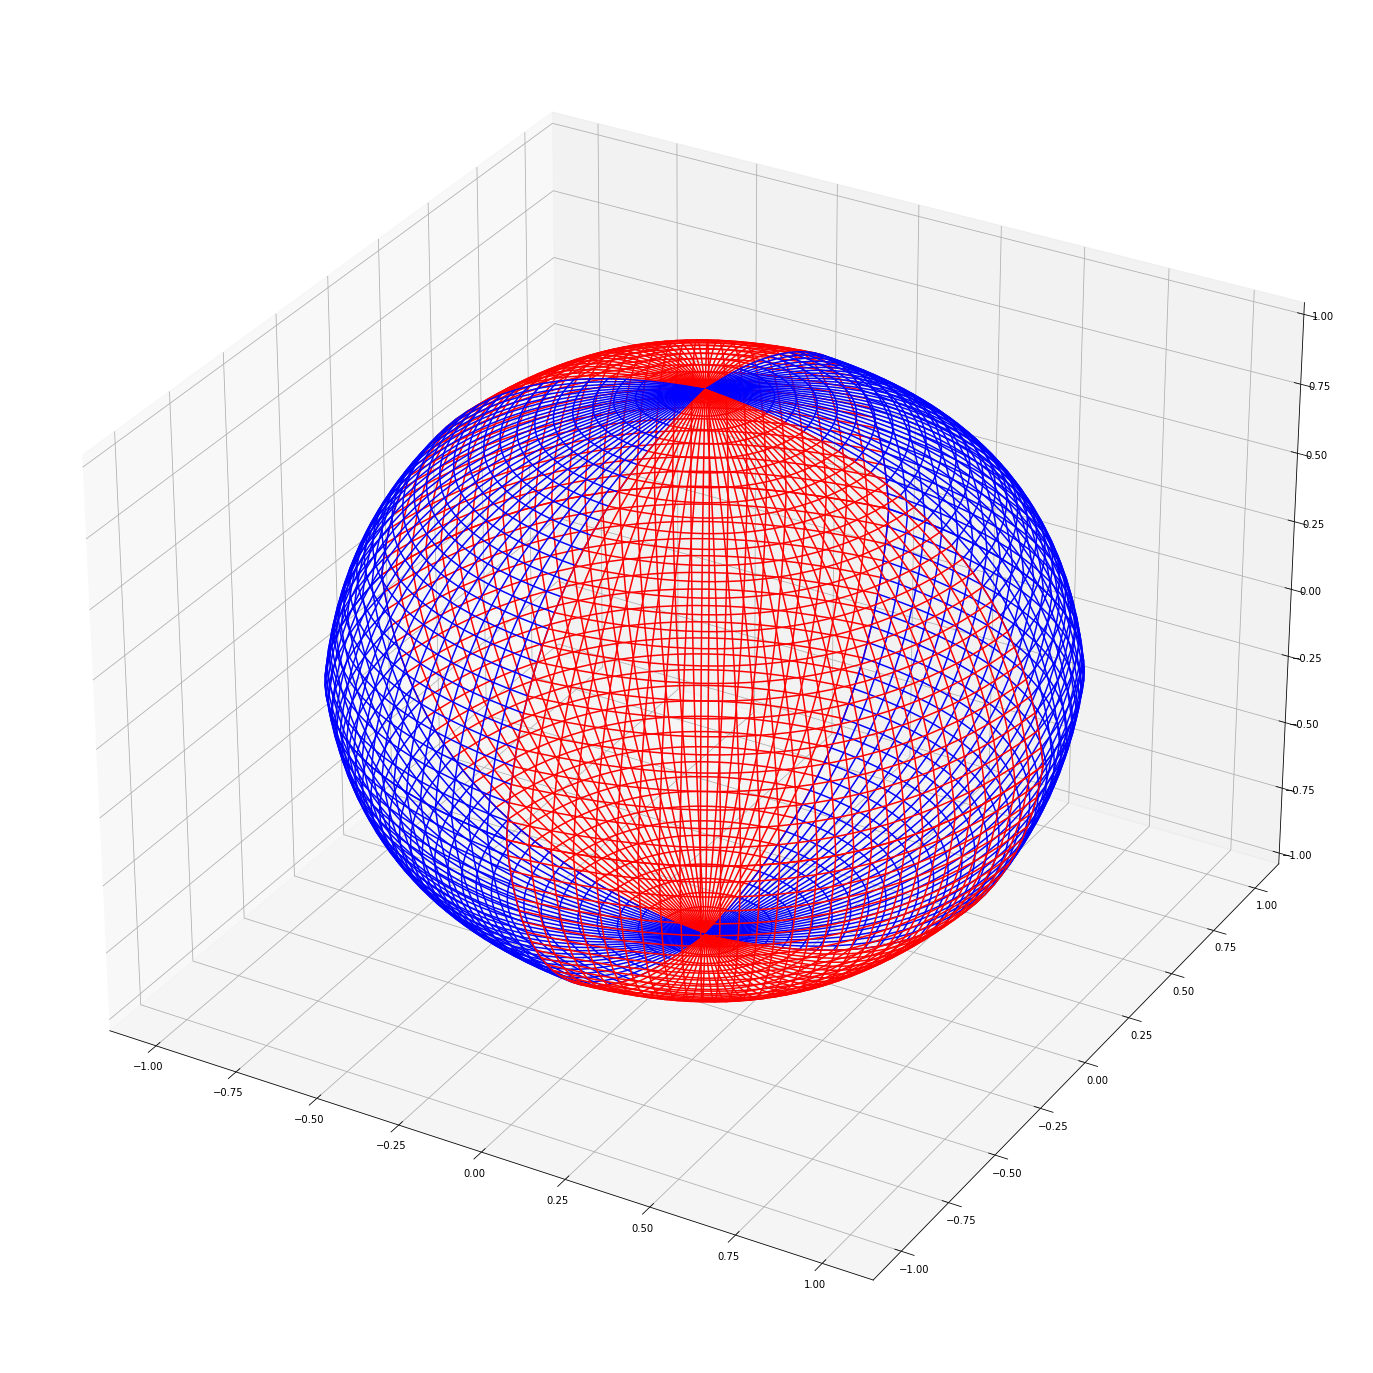

In [92]:

plt.rcParams['figure.figsize'] = [25,25]

xF = lambda u,v: u*(1.822194503355188 + u*-0.822194503355188) * (1.0 + v*(-0.177805496644792 + v*-0.822194503355208))
yF = lambda u,v: (1.0 + u*(-0.177805496644792 + u*-0.822194503355208)) *  (1.0 + v*(-0.177805496644792 + v*-0.822194503355208))
zF = lambda u,v: v*(1.822194503355188 + v*-0.822194503355188)

u = np.linspace(0.0, 1.0, 30)
v = np.linspace(0.0, 1.0, 30)

U, V = np.meshgrid(u, v)

X = xF(U, V)
Y = yF(U, V)
Z = zF(U, V)

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_wireframe(X, Y, Z, color='blue')
ax.plot_wireframe(X, -Y, Z, color='red')
ax.plot_wireframe(-X, Y, Z, color='red')
ax.plot_wireframe(-X, -Y, Z, color='blue')
ax.plot_wireframe(X, Y, -Z, color='blue')
ax.plot_wireframe(X, -Y, -Z, color='red')
ax.plot_wireframe(-X, Y, -Z, color='red')
ax.plot_wireframe(-X, -Y, -Z, color='blue')

plt.show()
